# **libraries**

In [115]:
import os
import glob
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from mtcnn import MTCNN


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# **Data Collection**

In [116]:
DATASET_PATH = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg"), recursive=True):
    person = os.path.basename(os.path.dirname(path)) 
    dataset.append({"person": person, "path": path})

dataset = pd.DataFrame(dataset)
dataset.head()

,person,path
0,Tyler_Hamilton,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
1,Tyler_Hamilton,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
2,Bernard_Siegel,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
3,Blythe_Danner,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
4,Blythe_Danner,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...


# **Data Exploration**

In [117]:
print('size of data:',dataset.shape)
print('-------------------------------------------------------')
image_counts = dataset["person"].value_counts()
count_people_has_1_imgs = (image_counts == 1).sum()
print('count of people that has 1 imgs:',count_people_has_1_imgs)
print('-------------------------------------------------------')
count_people_has_more_than_10_imgs = (image_counts >= 10).sum()
print('count of people that has more than or equal 10 imgs:',count_people_has_more_than_10_imgs)
print('-------------------------------------------------------')
count_people_has_more_than_1_imgs = (image_counts > 1).sum()
print('count of people that has more than 1 imgs:',count_people_has_more_than_1_imgs)

size of data: (13233, 2)
-------------------------------------------------------
count of people that has 1 imgs: 4069
-------------------------------------------------------
count of people that has more than or equal 10 imgs: 158
-------------------------------------------------------
count of people that has more than 1 imgs: 1680


In [118]:
df_show = []
columns = dataset . columns 
for i in columns : 
    types = dataset[i] . dtypes
    
    unique_data = dataset[i] . nunique()
                   
    NAN_value=dataset[i].isnull().sum() 
        
    duplicated= dataset.duplicated().sum()    
    df_show . append ([i , types , unique_data , NAN_value,duplicated])
        
df_info = pd . DataFrame (df_show)
df_info . columns =['Columns' , 'Types' ,'Unique_Data' , 'NAN value',"Duplicated"]




df_info.style.highlight_max(color = 'pink', axis = 0)

,Columns,Types,Unique_Data,NAN value,Duplicated
0,person,object,5749,0,0
1,path,object,13233,0,0


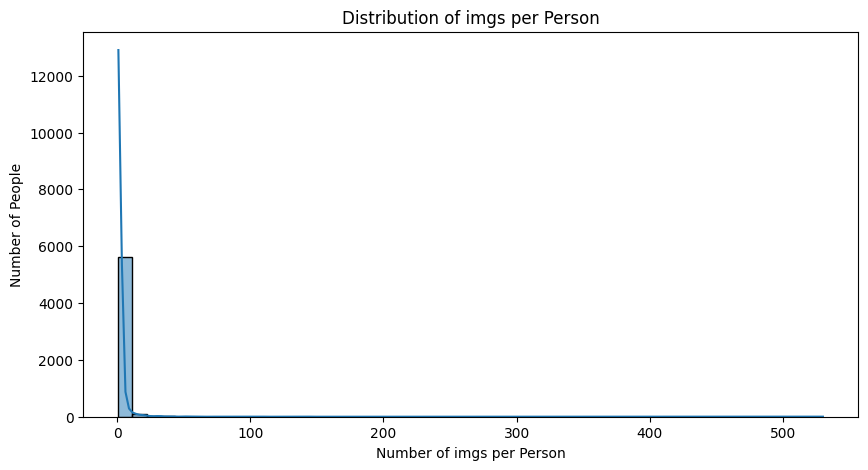

In [119]:
image_counts = dataset["person"].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(image_counts, bins=50, kde=True)
plt.xlabel("Number of imgs per Person")
plt.ylabel("Number of People")
plt.title("Distribution of imgs per Person")
plt.show()


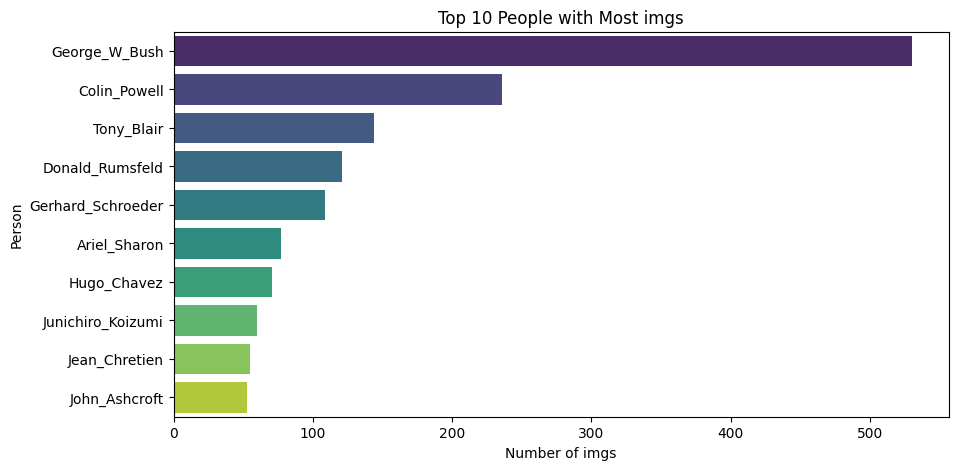

In [120]:
top_10_people = image_counts.head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_people.values, y=top_10_people.index, palette="viridis")
plt.xlabel("Number of imgs")
plt.ylabel("Person")
plt.title("Top 10 People with Most imgs")
plt.show()

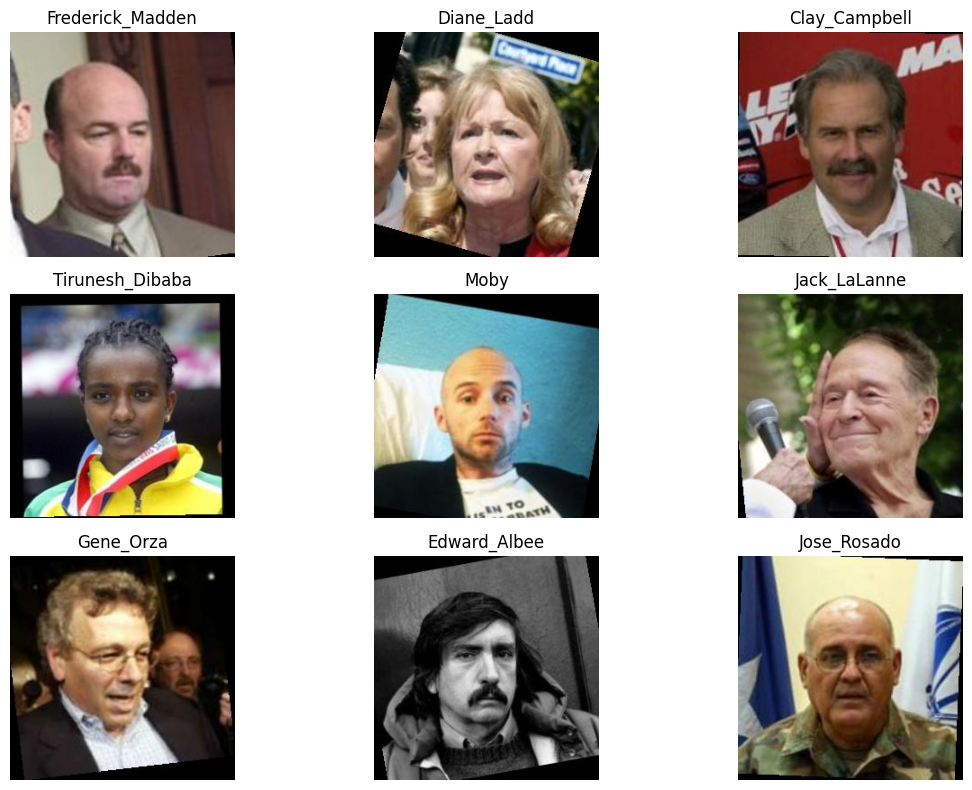

In [121]:
def plot_sample_imgs(dataset, num_samples=9):
    sample_people = random.sample(list(dataset["person"].unique()), num_samples)
    fig, axes = plt.subplots(3, 3, figsize=(12, 8))
    
    for ax, person in zip(axes.flat, sample_people):
        person_images = dataset[dataset["person"] == person]["path"].values
        img_path = random.choice(person_images)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax.imshow(img)
        ax.set_title(person)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

plot_sample_imgs(dataset)

# **Data Preprocessing**

In [122]:
# remove people with fewer than 5 images
filtered_dataset = dataset.groupby("person").filter(lambda x: len(x) >= 10)

# Limit each person to max 30 images
def limit_images(group):
    return group.sample(n=min(len(group), 30), random_state=42)

dataset = filtered_dataset.groupby("person").apply(limit_images).reset_index(drop=True)

print("Dataset size after filtering:", dataset.shape)

Dataset size after filtering: (2974, 2)


<ipython-input-122-105e2798cd72>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = filtered_dataset.groupby("person").apply(limit_images).reset_index(drop=True)


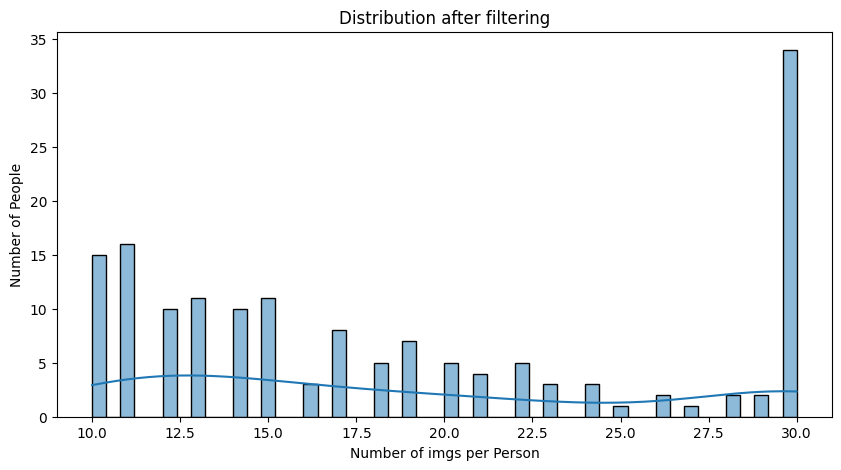

In [123]:
image_counts = dataset["person"].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(image_counts, bins=50, kde=True)
plt.xlabel("Number of imgs per Person")
plt.ylabel("Number of People")
plt.title("Distribution after filtering")
plt.show()


In [124]:
print('size of data:',dataset.shape)
print('-------------------------------------------------------')
image_counts = dataset["person"].value_counts()
count_people_after_filtering = (image_counts > 1).sum()
print('count of people after filtering:',count_people_after_filtering)

size of data: (2974, 2)
-------------------------------------------------------
count of people after filtering: 158


# Using MTCNN to Detect and Extract Face

In [125]:
detector = MTCNN()

# funcation to detect and extract face 
# resize to 160*160 for mtcnn and normalize

def extract_face(image_path, target_size=(160, 160)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    faces = detector.detect_faces(img)
    if len(faces) == 0:
        return None  
    
    x, y, width, height = faces[0]['box']
    
    x, y = max(x, 0), max(y, 0)
    width, height = max(width, 10), max(height, 10)
    
    face = img[y:y+height, x:x+width] 
    
    # resize to 160*160
    face = cv2.resize(face, target_size)
    face = np.array(face).astype("float32") / 255.0 
    return face


# Plot detected faces

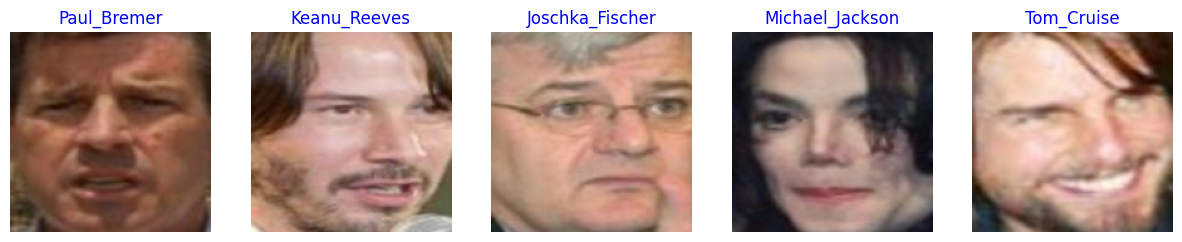

In [100]:
sample_images = dataset.sample(5)[["person", "path"]].values

plt.figure(figsize=(15, 5))
for i, (person_name, img_path) in enumerate(sample_images):
    face = extract_face(img_path)
    if face is not None:
        plt.subplot(1, 5, i+1)
        plt.imshow(face)
        plt.axis("off")
        plt.title(person_name, fontsize=12, color="blue") 
plt.show()
